___
# <font color= #d4b1e6> **Proyecto 2: Neural Style Transfer** </font>
- <Strong> Nombre de los integrantes: </Strong>  <font color="blue">`Sarah Lucía Beltrán, Priscila Cervantes Ramírez, Mónica Ibarra Herrera & Antonia Horburger` </font>
- <Strong> Materia: </Strong>  <font color="blue">`Aprendizaje Máquina` </font>
___

*Librerías a utlizar*

In [26]:
# Imports comunes
import os
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models


# TensorFlow / Keras imports (para la sección Keras)
from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K

In [27]:
# Rutas
CONTENT_DIR = Path('images/content')
STYLE_DIR = Path('images/style')
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [28]:
# Helpers (PyTorch)
IMG_SIZE = 512 # puede reducir si GPU limitada


loader = transforms.Compose([
transforms.Resize(IMG_SIZE),
transforms.CenterCrop(IMG_SIZE),
transforms.ToTensor()
])


unloader = transforms.ToPILImage()

In [29]:
# Carga imagen y la convierte a tensor normalizado
from pyexpat import features
from unittest import result

import cv2

def load_image_pil(image_path, img_size=512):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((img_size, img_size))
    return image

# def load_image_pil(path, size=IMG_SIZE):
#     image = Image.open(path).convert('RGB')
#     transform = transforms.Compose([
#         transforms.Resize(size),
#         transforms.ToTensor(),
#         transforms.Lambda(lambda x: x[:3, :, :])
#     ])
#     return transform(image).unsqueeze(0).to(DEVICE)


# Convierte tensor a PIL Image
def tensor_to_pil(tensor):
    tensor = tensor.cpu().clone().squeeze(0)
    tensor = torch.clamp(tensor, 0, 1)
    image = transforms.ToPILImage()(tensor)
    return image


# Matriz de Gram para cálculo de estilo
def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)


# Convierte tensor a PIL Image
def tensor_to_pil(tensor):
    tensor = tensor.cpu().clone().squeeze(0)
    tensor = torch.clamp(tensor, 0, 1)
    image = transforms.ToPILImage()(tensor)
    return image


# Matriz de Gram para cálculo de estilo
def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)


# Función de preservación de color (crominancia)
def preserve_color_np(content_tensor, stylized_tensor):
    # convierte a numpy
    content_np = content_tensor.cpu().numpy().squeeze().transpose(1,2,0)
    stylized_np = stylized_tensor.cpu().numpy().squeeze().transpose(1,2,0)
    # convierte a YCrCb
    import cv2
    content_ycrcb = cv2.cvtColor((content_np*255).astype(np.uint8), cv2.COLOR_RGB2YCrCb)
    stylized_ycrcb = cv2.cvtColor((stylized_np*255).astype(np.uint8), cv2.COLOR_RGB2YCrCb)
    stylized_ycrcb[:,:,1:] = content_ycrcb[:,:,1:]
    result = cv2.cvtColor(stylized_ycrcb, cv2.COLOR_YCrCb2RGB)/255.0
    return torch.tensor(result.transpose(2,0,1), device=DEVICE).unsqueeze(0).float()


# Convierte imagen a tensor con normalización ImageNet
def image_to_tensor(image):
    # si ya es tensor lo retorna
    if isinstance(image, torch.Tensor): return image
    transform = transforms.Compose([
    transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0).to(DEVICE)

*Definición de pérdidas de contenido y estilo*

In [30]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight=1.0):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.loss = 0.0

    def forward(self, input):
        self.loss = F.mse_loss(input * self.weight, self.target)
        return input


class StyleLoss(nn.Module):
    def __init__(self, target_feature, weight=1.0):
        super(StyleLoss, self).__init__()
        self.weight = weight
        self.target = gram_matrix(target_feature).detach() * self.weight
        self.loss = 0.0

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G * self.weight, self.target)
        return input

*Construcción del modelo con pérdidas insertadas*

In [31]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
    style_img, content_img,
    content_layers=['conv_4'],
    style_layers=['conv_1','conv_2','conv_3','conv_4','conv_5'],
    content_weight=1e5, style_weight=1e10,
    style_layer_weights=None):


    class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            self.mean = torch.tensor(mean).view(-1,1,1).to(DEVICE)
            self.std = torch.tensor(std).view(-1,1,1).to(DEVICE)
        def forward(self, img):
            return (img - self.mean) / self.std

    normalization = Normalization(normalization_mean, normalization_std)

    model = nn.Sequential(normalization)


    content_losses = []
    style_losses = []


    if style_layer_weights is None:
        style_layer_weights = {name:1.0 for name in style_layers}


    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d): i += 1; name=f'conv_{i}'
        elif isinstance(layer, nn.ReLU): name=f'relu_{i}'; layer=nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d): name=f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d): name=f'bn_{i}'
        else: name=f'layer_{i}'
        model.add_module(name, layer)


        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target, weight=content_weight)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)


        if name in style_layers:
            target_feature = model(style_img).detach()
            w = style_layer_weights.get(name, 1.0)
            style_loss = StyleLoss(target_feature, weight=style_weight * w)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)


    for j in range(len(model)-1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss): break
        model = model[:(j+1)]


        return model, style_losses, content_losses

*Función principal de transferencia de estilo PyTorch*

In [32]:
def run_style_transfer_pytorch(cnn, normalization_mean, normalization_std,
    content_img, style_img, input_img,
    num_steps=300, style_weight=1e6, content_weight=1e0,
    tv_weight=1e-6, style_layer_weights=None,
    print_steps=50):
    content_layers = ['conv_4']
    style_layers = ['conv_1','conv_2','conv_3','conv_4','conv_5']


    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img,
        content_layers, style_layers, content_weight, style_weight, style_layer_weights)


    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])


    run = [0]
    while run[0] <= num_steps:
        def closure():
            with torch.no_grad(): input_param.clamp_(0,1)
            optimizer.zero_grad()
            model(input_param)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            tv = tv_weight * (torch.sum(torch.abs(input_param[:,:,1:,:]-input_param[:,:,:-1,:])) + torch.sum(torch.abs(input_param[:,:,:,1:]-input_param[:,:,:,:-1])))
            loss = style_score + content_score + tv
            loss.backward()
            run[0] += 1
            if run[0]%print_steps==0:
                print(f"Iter {run[0]}: Style {style_score.item():.2e} Content {content_score.item():.2e} TV {tv.item():.2e}")
            return loss
        optimizer.step(closure)


    with torch.no_grad(): input_param.clamp_(0,1)
    return input_param.detach()

*Función envolvente para control completo (Contenido, Textura, Color)*

In [33]:
def stylize_with_controls(content_path, style_path, out_path,
        content_weight=1e5, style_weight=1e10,
        tv_weight=1e-6, num_steps=200,
        preserve_color=True, style_layer_weights=None,
        init='content'):
    content = image_to_tensor(load_image_pil(content_path, IMG_SIZE))
    style = image_to_tensor(load_image_pil(style_path, IMG_SIZE))
    input_img = content.clone() if init=='content' else torch.randn_like(content).to(DEVICE)


    cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval()
    cnn_norm_mean = torch.tensor([0.485,0.456,0.406]).to(DEVICE)
    cnn_norm_std = torch.tensor([0.229,0.224,0.225]).to(DEVICE)


    output = run_style_transfer_pytorch(cnn, cnn_norm_mean, cnn_norm_std, content, style, input_img,
        num_steps=num_steps, style_weight=style_weight,
        content_weight=content_weight, tv_weight=tv_weight,
        style_layer_weights=style_layer_weights)
    if preserve_color: output = preserve_color_np(content, output)
    tensor_to_pil(output).save(out_path)
    return output

*Ejecución*

In [34]:
example_style_layer_weights = {'conv_1':1.5, 'conv_2':1.2, 'conv_3':0.8, 'conv_4':0.5, 'conv_5':0.3}

content_files = sorted(list(CONTENT_DIR.glob('*.jpg')) + list(CONTENT_DIR.glob('*.png')))[:5]
style_files = sorted(list(STYLE_DIR.glob('*.jpg')) + list(STYLE_DIR.glob('*.png')))[:5]


for c in content_files:
    for s in style_files:
        out_name = OUTPUT_DIR / f"{c.stem}__{s.stem}__styled.jpg"
        print(f'Procesando {c.name} con {s.name}')
        stylize_with_controls(str(c), str(s), str(out_name),
            content_weight=1e5, style_weight=1e10,
            tv_weight=1e-6, num_steps=200,
            preserve_color=True,
            style_layer_weights=example_style_layer_weights)

Procesando portrait1.jpg con vangogh.jpg


C:\Users\sarah\AppData\Local\Temp\ipykernel_22196\816088135.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1,1,1).to(DEVICE)
C:\Users\sarah\AppData\Local\Temp\ipykernel_22196\816088135.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1,1,1).to(DEVICE)


Iter 50: Style 4.86e+16 Content 6.76e+11 TV 1.68e-01
Iter 100: Style 4.60e+15 Content 6.80e+11 TV 1.71e-01
Iter 150: Style 1.45e+15 Content 6.82e+11 TV 1.71e-01
Iter 200: Style 6.30e+14 Content 6.86e+11 TV 1.73e-01


In [43]:
output = stylize_with_controls(
    content_path='images/content/portrait1.jpg',
    style_path='images/style/vangogh.jpg',
    out_path='outputs/test_output.jpg',
    content_weight=1e5,       # control de cuánto prevalece el contenido
    style_weight=1e7,        # control de cuánto prevalece el estilo
    tv_weight=1e-6,           # suavizado de textura
    num_steps=80,             # número de iteraciones para prueba rápida
    preserve_color=False,      # mantener colores del contenido
    style_layer_weights = {
    'conv_1': 2.0,
    'conv_2': 1.5,
    'conv_3': 1.0,
    'conv_4': 0.2,
    'conv_5': 0.1},
    init='content'            # iniciar con la imagen aleatoria
)

c:\Users\sarah\anaconda3\envs\ml_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sarah\anaconda3\envs\ml_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\sarah\AppData\Local\Temp\ipykernel_22196\816088135.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1,1,1).to(DEVICE)
C:\Users\sarah\AppData\Local\Temp

Iter 50: Style 1.60e+11 Content 2.80e+11 TV 1.63e-01
Iter 100: Style 1.05e+11 Content 3.01e+11 TV 1.99e-01


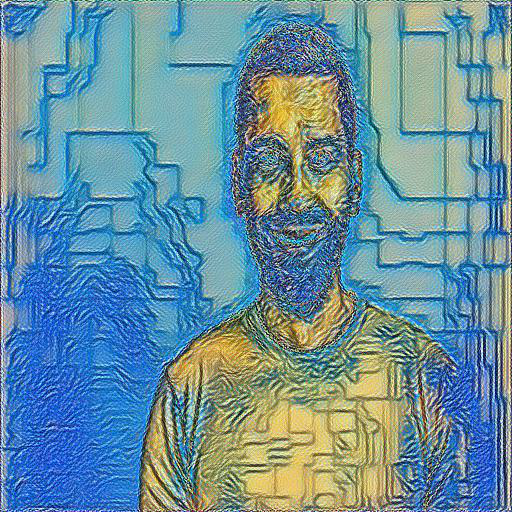

In [44]:
Image.open('outputs/test_output.jpg')